In [23]:
#bring in the packages!
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandasql as ps
# some display settings for notebook
pd.set_option("display.max_columns",None)
sns.set_theme()


# Quick Introduction about the Fantasy League Game and Dataset.

## What is Fantasy League?

The Premier League Fantasy Football, often referred to as FPL [(Fantasy Premier League)](https://fantasy.premierleague.com), is an online fantasy sports game based on the English Premier League (EPL), which is one of the top football leagues in the world. Here's a brief description of the Premier League Fantasy League:

**Concept**: FPL is a virtual football management game where participants create their own fantasy football teams by selecting real-life players from the English Premier League. These virtual teams then compete against each other based on the real-life performance of the selected players during Premier League matches.

**Team Creation**: Participants start by selecting a squad of 15 players from the Premier League teams while adhering to a predefined budget. The squad typically consists of two goalkeepers, five defenders, five midfielders, and three forwards.

**Player Selection**: Participants can choose from a wide range of Premier League players, each assigned a specific value (price) based on their expected performance. Balancing the budget while selecting top-performing players is a key strategy.

**Scoring**: Points are awarded to FPL teams based on the actual performance of their selected players in Premier League matches. Points are earned for actions such as goals, assists, clean sheets, saves (for goalkeepers), and more. Points are deducted for actions like yellow and red cards.

**Transfers and Strategy**: Throughout the Premier League season, participants can make a limited number of transfers to improve their squads. Managing injuries, suspensions, and fixtures is crucial for success. Captains and vice-captains can be chosen each gameweek for bonus points.

**Duration**: The game is played for an 9 months of the year, and thousands of enthusiast compete to be the top performing team.

In [24]:
# Lets look at the combined game files from last season's game

game = pd.read_csv('Fantasy-Premier-League/data/2022-23/gws/merged_gw.csv')
players_df = pd.read_csv('Fantasy-Premier-League/data/2022-23/cleaned_players.csv')
teams_df = pd.read_csv('Fantasy-Premier-League/data/2022-23/teams.csv')

# Oh Ok, so what are we going to do with the data now?

The data is web-scraped everyweek from the main FPL site and this is stored in this [github repo!](https://github.com/vaastav/Fantasy-Premier-League). Follow the link and check it out for a more in-depth description. But roughly it contains all player data and game statistics for about 5 years. We have to do some preprocessing of the data. The poisson regression will be using last season's data (2022-2023 season), we will be doing some cleaning up of the data in this notebook and output our main data modelling source.

In [25]:
#Basic data cleaning game dataframe as it is the main focuse
rows, columns = game.shape

print(f"Number of rows: {rows}")
print(f"Number of columns: {columns}")
print(f"DataFrame attributes:\n")
game.info()

Number of rows: 26505
Number of columns: 41
DataFrame attributes:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26505 entries, 0 to 26504
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        26505 non-null  object 
 1   position                    26505 non-null  object 
 2   team                        26505 non-null  object 
 3   xP                          26505 non-null  float64
 4   assists                     26505 non-null  int64  
 5   bonus                       26505 non-null  int64  
 6   bps                         26505 non-null  int64  
 7   clean_sheets                26505 non-null  int64  
 8   creativity                  26505 non-null  float64
 9   element                     26505 non-null  int64  
 10  expected_assists            26505 non-null  float64
 11  expected_goal_involvements  26505 non-null  float64
 12  expected_goals       

Most fields are properly formated, but we will need to modify kickoff_time, and other text based object types.

In [26]:
# Check for non-string entries
non_string_entries = game[~game['name'].apply(lambda x: isinstance(x, str) or pd.isna(x))]
non_string_entries2 = game[~game['position'].apply(lambda x: isinstance(x, str) or pd.isna(x))]
non_string_entries3 = game[~game['team'].apply(lambda x: isinstance(x, str) or pd.isna(x))]
print(f"Non-string entries:\n name {non_string_entries}\n, position {non_string_entries2}\n, team {non_string_entries3}\n")



Non-string entries:
 name Empty DataFrame
Columns: [name, position, team, xP, assists, bonus, bps, clean_sheets, creativity, element, expected_assists, expected_goal_involvements, expected_goals, expected_goals_conceded, fixture, goals_conceded, goals_scored, ict_index, influence, kickoff_time, minutes, opponent_team, own_goals, penalties_missed, penalties_saved, red_cards, round, saves, selected, starts, team_a_score, team_h_score, threat, total_points, transfers_balance, transfers_in, transfers_out, value, was_home, yellow_cards, GW]
Index: []
, position Empty DataFrame
Columns: [name, position, team, xP, assists, bonus, bps, clean_sheets, creativity, element, expected_assists, expected_goal_involvements, expected_goals, expected_goals_conceded, fixture, goals_conceded, goals_scored, ict_index, influence, kickoff_time, minutes, opponent_team, own_goals, penalties_missed, penalties_saved, red_cards, round, saves, selected, starts, team_a_score, team_h_score, threat, total_points, tran

In [27]:
# Convert the specified fields to the new pandas string dtype
fields_to_convert = ['name', 'position', 'team']
game[fields_to_convert] = game[fields_to_convert].astype('string')

# Perform an info check on the DataFrame
game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26505 entries, 0 to 26504
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        26505 non-null  string 
 1   position                    26505 non-null  string 
 2   team                        26505 non-null  string 
 3   xP                          26505 non-null  float64
 4   assists                     26505 non-null  int64  
 5   bonus                       26505 non-null  int64  
 6   bps                         26505 non-null  int64  
 7   clean_sheets                26505 non-null  int64  
 8   creativity                  26505 non-null  float64
 9   element                     26505 non-null  int64  
 10  expected_assists            26505 non-null  float64
 11  expected_goal_involvements  26505 non-null  float64
 12  expected_goals              26505 non-null  float64
 13  expected_goals_conceded     265

In [28]:
#converting kickoff_time into datetime format
# 1) Convert the "kickoff_time" column into a proper datetime dtype
game['kickoff_time'] = pd.to_datetime(game['kickoff_time'])

# 2) Create two new columns for date and time
game['kickoff_date'] = game['kickoff_time'].dt.date
game['kickoff_hour'] = game['kickoff_time'].dt.time

# Convert "kickoff_date" to date dtype and "kickoff_hour" to time dtype
game['kickoff_date'] = pd.to_datetime(game['kickoff_date']).dt.date
game['kickoff_hour'] = pd.to_timedelta(game['kickoff_hour'].astype(str)).dt.components.hours



In [29]:
#upon review I think I should recatorize the columns position and team to dtype catergory, this will be usefull for modelling later

# Convert the "position" and "team" columns to category dtype
game['position'] = game['position'].astype('category')
game['team'] = game['team'].astype('category')

## Team points 

Sometimes the team performence can be influence indivisual score and performance of the player. In the next few cells, I create an total team points field and join it back to our original dataset.


In [30]:

# list some key attributes 

keep_fields = ['team','GW','kickoff_time','kickoff_date','kickoff_hour','round', 'team_a_score', 'team_h_score','was_home']


#We want to summerize all points accumalated by the teams by their players, per game week played. 
teampoints = (game
              .groupby(['team', 'GW','kickoff_time'])
              .agg(
                  total_points=('total_points', 'sum'),
                  frequency=('total_points', 'size')  # Adding frequency (count) for each group
              )
              # .unstack()
             )


#We keep only the match
team = game[keep_fields].drop_duplicates()

team = pd.merge(team
        ,teampoints# drop these fields that we do not need
        ,how='left'
        ,left_on=['team','GW','kickoff_time']
        ,right_on=['team','GW','kickoff_time']
        ,suffixes=['','_t']
        )

#.drop_duplicates()
team


,team,GW,kickoff_time,kickoff_date,kickoff_hour,round,team_a_score,team_h_score,was_home,total_points,frequency
0,Southampton,1,2022-08-06 14:00:00+00:00,2022-08-06,14,1,1,4,False,24,28
1,Bournemouth,1,2022-08-06 14:00:00+00:00,2022-08-06,14,1,0,2,True,64,24
2,Chelsea,1,2022-08-06 16:30:00+00:00,2022-08-06,16,1,1,0,False,68,30
3,Newcastle,1,2022-08-06 14:00:00+00:00,2022-08-06,14,1,0,2,True,71,30
4,Leicester,1,2022-08-07 13:00:00+00:00,2022-08-07,13,1,2,2,True,38,28
...,...,...,...,...,...,...,...,...,...,...,...
755,Man Utd,38,2023-05-28 15:30:00+00:00,2023-05-28,15,38,1,2,True,49,39
756,Man City,38,2023-05-28 15:30:00+00:00,2023-05-28,15,38,0,1,False,30,34
757,Arsenal,38,2023-05-28 15:30:00+00:00,2023-05-28,15,38,0,5,True,90,36
758,Aston Villa,38,2023-05-28 15:30:00+00:00,2023-05-28,15,38,1,2,True,40,42


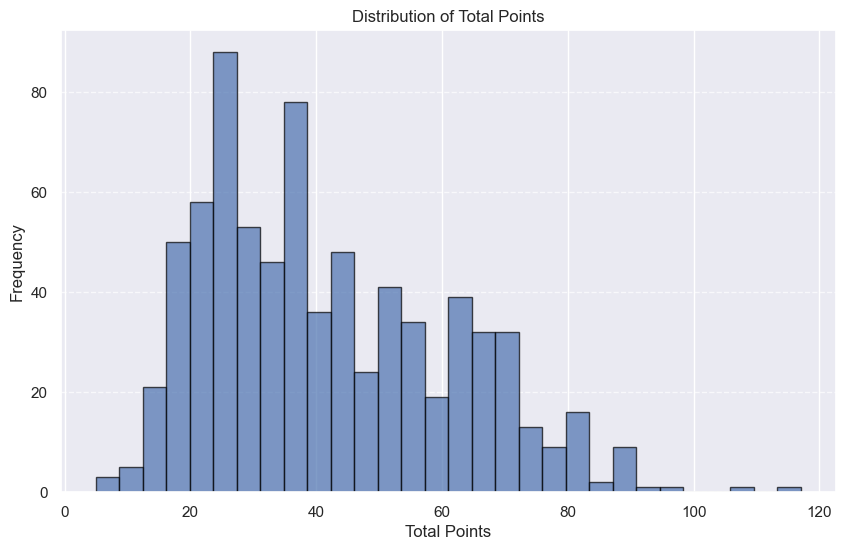

In [31]:
#To make sure there is any extreme outliers in the data we will plot the results.
# It is much better to visualize our problem
import matplotlib.pyplot as plt


# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(team['total_points'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Total Points')
plt.xlabel('Total Points')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [32]:
# Filtering teams with total_points over/under 100
# this is to get a feel if there is any odd team performances before we create new columns to 
# be use by our model.
teams_under_100 = team[team['total_points'] < 10]

teams_under_100

matching_teams = pd.merge(game, teams_under_100[['team', 'GW']], on=['team', 'GW'], how='inner')
matching_teams


,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,starts,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,kickoff_date,kickoff_hour
0,Junior Stanislas,MID,Bournemouth,0.0,0,0,0,0,0.0,58,0.0,0.0,0.0,0.00,36,0,0,0.0,0.0,2022-08-27 14:00:00+00:00,0,12,0,0,0,0,4,0,5341,0,0,9,0.0,0,-2093,103,2196,49,False,0,4,2022-08-27,14
1,Lewis Cook,MID,Bournemouth,0.0,0,0,11,0,0.3,67,0.0,0.0,0.0,0.00,36,7,0,0.7,6.4,2022-08-27 14:00:00+00:00,76,12,0,0,0,0,4,0,5132,0,0,9,0.0,2,-509,265,774,49,False,0,4,2022-08-27,14
2,Jack Stacey,DEF,Bournemouth,-1.7,0,0,0,0,0.0,65,0.0,0.0,0.0,0.00,36,0,0,0.0,0.0,2022-08-27 14:00:00+00:00,0,12,0,0,0,0,4,0,4647,0,0,9,0.0,0,-392,114,506,44,False,0,4,2022-08-27,14
3,Owen Bevan,DEF,Bournemouth,-0.3,0,0,3,0,0.0,598,0.0,0.0,0.0,0.00,36,1,0,0.0,0.2,2022-08-27 14:00:00+00:00,8,12,0,0,0,0,4,0,0,0,0,9,0.0,1,0,0,0,40,False,0,4,2022-08-27,14
4,Mark Travers,GK,Bournemouth,0.5,0,0,17,0,0.0,72,0.0,0.0,0.0,0.00,36,9,0,3.2,31.8,2022-08-27 14:00:00+00:00,90,12,0,0,0,0,4,4,51477,0,0,9,0.0,-1,-3382,1217,4599,45,False,0,4,2022-08-27,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Nathan Collins,DEF,Wolves,0.4,0,0,5,0,0.2,516,0.0,0.0,0.0,1.39,334,2,0,2.3,22.8,2023-04-29 14:00:00+00:00,45,5,0,0,0,0,34,0,58053,0,0,6,0.0,0,-563,107,670,43,False,0,34,2023-04-29,14
100,Matheus Santos Carneiro Da Cunha,FWD,Wolves,2.8,0,0,0,0,0.0,682,0.0,0.0,0.0,0.00,334,0,0,0.0,0.0,2023-04-29 14:00:00+00:00,0,5,0,0,0,0,34,0,21877,0,0,6,0.0,0,1262,4836,3574,53,False,0,34,2023-04-29,14
101,Jonathan Castro Otto,DEF,Wolves,0.0,0,0,0,0,0.0,477,0.0,0.0,0.0,0.00,334,0,0,0.0,0.0,2023-04-29 14:00:00+00:00,0,5,0,0,0,0,34,0,34428,0,0,6,0.0,0,-209,80,289,43,False,0,34,2023-04-29,14
102,João Filipe Iria Santos Moutinho,MID,Wolves,0.6,0,0,0,0,0.0,503,0.0,0.0,0.0,0.00,334,0,0,0.0,0.0,2023-04-29 14:00:00+00:00,0,5,0,0,0,0,34,0,38614,0,0,6,0.0,0,-320,380,700,46,False,0,34,2023-04-29,14


In [19]:
#here we restrict our columns so we can do sql joins later and accurately obtain previous game total points, 
fields = ['name', 'team', 'GW', 'kickoff_time','total_points']
game_subset = game[fields].sort_values(by=fields)

#This is add a new column with a better count of the games played in a season. GW has some issues.
game_subset['row_count'] = game_subset.groupby(['name', 'team']).cumcount() + 1

#test out the game count with a specific player!
game_subset.query("name == 'Frank Onyeka'")

,name,team,GW,kickoff_time,total_points,row_count
267,Frank Onyeka,Brentford,1,2022-08-07 13:00:00+00:00,0,1
843,Frank Onyeka,Brentford,2,2022-08-13 16:30:00+00:00,1,2
1429,Frank Onyeka,Brentford,3,2022-08-20 14:00:00+00:00,0,3
2025,Frank Onyeka,Brentford,4,2022-08-27 14:00:00+00:00,0,4
2628,Frank Onyeka,Brentford,5,2022-08-30 18:30:00+00:00,1,5
3244,Frank Onyeka,Brentford,6,2022-09-03 14:00:00+00:00,1,6
3779,Frank Onyeka,Brentford,8,2022-09-18 11:00:00+00:00,1,7
4312,Frank Onyeka,Brentford,9,2022-10-01 14:00:00+00:00,1,8
4953,Frank Onyeka,Brentford,10,2022-10-08 14:00:00+00:00,1,9
5595,Frank Onyeka,Brentford,11,2022-10-14 19:00:00+00:00,6,10


## Some last game performence information

An additional field we should create is a "previous points gained" by the player, often I have noticed scores have some autoregresive properties. The following cells are dedicated towards implementing this field requirement.  

In [38]:
#we add our team points data 
addtotalteampoints_sql = """
SELECT 
    a.*,
    b.total_points as TotalTeamPoints,
    (a.total_points/b.total_points) as  player_contribution 
    
FROM 
    game_subset a
LEFT JOIN 
    team b 
ON 
    a.team = b.team 
    AND a.kickoff_time = b.kickoff_time
ORDER BY 
    a.name, 
    a.team, 
    a.kickoff_time
"""

# Execute the query using pandasql
game_subset_total_team_points_df = ps.sqldf(addtotalteampoints_sql, locals())

print(f"To check dataframe dimensions: \n{game_subset.shape}")
print(f"To check new merge for duplicates entries: \n{game_subset_total_team_points_df.shape}")
game_subset_total_team_points_df

To check dataframe dimensions: 
(26505, 6)
To check new merge for duplicates entries: 
(26505, 8)


,name,team,GW,kickoff_time,total_points,row_count,TotalTeamPoints,player_contribution
0,Aaron Cresswell,West Ham,1,2022-08-07 15:30:00.000000,1,1,20,0
1,Aaron Cresswell,West Ham,2,2022-08-14 13:00:00.000000,2,2,23,0
2,Aaron Cresswell,West Ham,3,2022-08-21 13:00:00.000000,0,3,19,0
3,Aaron Cresswell,West Ham,4,2022-08-28 13:00:00.000000,6,4,64,0
4,Aaron Cresswell,West Ham,5,2022-08-31 18:45:00.000000,2,5,35,0
...,...,...,...,...,...,...,...,...
26500,Çaglar Söyüncü,Leicester,34,2023-05-01 19:00:00.000000,10,34,35,0
26501,Çaglar Söyüncü,Leicester,35,2023-05-08 14:00:00.000000,0,35,31,0
26502,Çaglar Söyüncü,Leicester,36,2023-05-15 19:00:00.000000,0,36,19,0
26503,Çaglar Söyüncü,Leicester,37,2023-05-22 19:00:00.000000,0,37,55,0


In [40]:

# we want to create a previous total_point from the last game to be used as prediction input for our model.
# this is only past performance information to be used as inference for the next game at hand.


past_game_info_sql = """
SELECT 
    a.name, 
    a.team, 
    a.kickoff_time, 
    a.GW, 
    a.total_points, 
    a.row_count,
    a.TotalTeamPoints,
    b.total_points as previous_points,
    b.TotalTeamPoints as previous_TotalTeamPoints

FROM 
    game_subset_total_team_points_df a
LEFT JOIN 
    game_subset_total_team_points_df b 
ON 
    a.name = b.name 
    AND a.team = b.team 
    AND a.kickoff_time > b.kickoff_time
    AND a.row_count-b.row_count <=1
ORDER BY 
    a.name, 
    a.team, 
    a.kickoff_time,
    b.GW
"""

# Execute the query using pandasql
result = ps.sqldf(past_game_info_sql, locals())

result

,name,team,kickoff_time,GW,total_points,row_count,TotalTeamPoints,previous_points,previous_TotalTeamPoints
0,Aaron Cresswell,West Ham,2022-08-07 15:30:00.000000,1,1,1,20,NaN,NaN
1,Aaron Cresswell,West Ham,2022-08-14 13:00:00.000000,2,2,2,23,1.0,20.0
2,Aaron Cresswell,West Ham,2022-08-21 13:00:00.000000,3,0,3,19,2.0,23.0
3,Aaron Cresswell,West Ham,2022-08-28 13:00:00.000000,4,6,4,64,0.0,19.0
4,Aaron Cresswell,West Ham,2022-08-31 18:45:00.000000,5,2,5,35,6.0,64.0
...,...,...,...,...,...,...,...,...,...
26500,Çaglar Söyüncü,Leicester,2023-05-01 19:00:00.000000,34,10,34,35,2.0,33.0
26501,Çaglar Söyüncü,Leicester,2023-05-08 14:00:00.000000,35,0,35,31,10.0,35.0
26502,Çaglar Söyüncü,Leicester,2023-05-15 19:00:00.000000,36,0,36,19,0.0,31.0
26503,Çaglar Söyüncü,Leicester,2023-05-22 19:00:00.000000,37,0,37,55,0.0,19.0


In [47]:
# Joining the game DataFrame with result to add the 'row_count' and 'previous_points' and 'previous_TotalTeamPoints' columns
game_two = pd.merge(game, result[['name', 'team', 'GW','row_count', 'previous_points','previous_TotalTeamPoints']], 
                    on=['name', 'team','GW'], 
                    how='left')




In [48]:
#save file to be used by other notebooks
# run this last!

game_two.to_csv('game_season_cleaned.csv', index=False)

In [46]:
#display data
#game.info()
#teampoints
#29447 rows × 6 columns


#random player sample testing just to see if our new columns created work
result.query("name == 'Joel Matip'")

,name,team,kickoff_time,GW,total_points,row_count,TotalTeamPoints,previous_points,previous_TotalTeamPoints
12032,Joel Matip,Liverpool,2022-08-06 11:30:00.000000,1,1,1,36,NaN,NaN
12033,Joel Matip,Liverpool,2022-08-15 19:00:00.000000,2,0,2,34,1.0,36.0
12034,Joel Matip,Liverpool,2022-08-22 19:00:00.000000,3,0,3,27,0.0,34.0
12035,Joel Matip,Liverpool,2022-08-27 14:00:00.000000,4,0,4,117,0.0,27.0
12036,Joel Matip,Liverpool,2022-08-31 19:00:00.000000,5,0,5,45,0.0,117.0
12037,Joel Matip,Liverpool,2022-09-03 11:30:00.000000,6,1,6,43,0.0,45.0
12038,Joel Matip,Liverpool,2022-10-01 14:00:00.000000,9,1,7,35,1.0,43.0
12039,Joel Matip,Liverpool,2022-10-09 15:30:00.000000,10,1,8,34,1.0,35.0
12040,Joel Matip,Liverpool,2022-10-16 15:30:00.000000,11,0,9,62,1.0,34.0
12041,Joel Matip,Liverpool,2022-10-19 18:30:00.000000,12,0,10,65,0.0,62.0
